In [22]:
#importing same packages as my last project
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from keras.models import Model, Sequential
from keras import layers
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical 
import tensorflow
from skimage.io import imread
from skimage.transform import resize
import cv2
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(21)

In [4]:
main_dir = 'benignmalignant/'
data_dir = os.listdir('benignmalignant/')
print(data_dir)

['test', 'train']


In [5]:
for _set in ['test', 'train']:
    x_benign = len(os.listdir(main_dir + _set + '/benign'))
    x_malignant = len(os.listdir(main_dir + _set + '/malignant'))
    print('Set: {}, Benign Images: {}, Malignant Images: {}, Total: {}'.format(_set, x_benign,
                                                                                x_malignant, (x_benign + x_malignant)))

Set: test, Benign Images: 360, Malignant Images: 300, Total: 660
Set: train, Benign Images: 1440, Malignant Images: 1197, Total: 2637


In [6]:
benign_traindir = 'benignmalignant/train/benign'
malignant_traindir = 'benignmalignant/train/malignant'
benign_testdir = 'benignmalignant/test/benign'
malignant_testdir = 'benignmalignant/test/malignant'

In [12]:
#Using RGB values to load and convert images to numpy arrays for faster computing and less memory use
loading = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
#loading traing images
btrain = [loading(os.path.join(benign_traindir, filename)) for filename in os.listdir(benign_traindir)]
mtrain = [loading(os.path.join(malignant_traindir, filename)) for filename in os.listdir(malignant_traindir)]

#loading test images
btest = [loading(os.path.join(benign_testdir, filename)) for filename in os.listdir(benign_testdir)]
mtest = [loading(os.path.join(malignant_testdir, filename)) for filename in os.listdir(malignant_testdir)]

In [13]:
n_btrain = np.array(btrain, dtype='uint8')
n_mtrain = np.array(mtrain, dtype='uint8')

n_btest = np.array(btest, dtype='uint8')
n_mtest = np.array(mtest, dtype='uint8')

type(n_btrain) #testing code success

numpy.ndarray

In [14]:
#converting to binary data where 1=malignant and 0=benign
x_btrain = np.zeros(n_btrain.shape[0])
x_mtrain = np.ones(n_mtrain.shape[0])

x_btest = np.zeros(n_btest.shape[0])
x_mtest = np.ones(n_mtest.shape[0])

x_mtrain #<---checking

array([1., 1., 1., ..., 1., 1., 1.])

In [15]:
x_train = np.concatenate((n_btrain, n_mtrain), axis=0) 
y_train = np.concatenate((x_btrain, x_mtrain), axis=0)

x_test = np.concatenate((n_btest, n_mtest), axis=0)
y_test = np.concatenate((x_btest, x_mtest), axis=0)

print("Shape of X_train: ", x_train.shape) 
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

y_test

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
#Shuffling to ensure samples are independent of each other and to minimize 
#the risk of creating batches that don't represent the data
sh1 = np.arange(x_train.shape[0])
np.random.shuffle(sh1)
x_train = x_train[sh1]
y_train = y_train[sh1]

sh2 = np.arange(x_test.shape[0])
np.random.shuffle(sh2)
x_test = x_test[sh2]
y_test = y_test[sh2]

#Testing the shuffle:
print("Shuffled images: ", sh2)

Shuffled images:  [634 169 421 291 623 375 463 156 394 340  32 322 617 254  43 312 232 649
 472  86 437 353 181 626 139 490 569 194 268 593 520 352 253  60 256 549
 576  76 632 465   4  30 480 242 167  42 356 241  61 271 536 417 597 297
 288 168 438  18 630 283 229 498 584 380 595 300 589  68 612 219 514 319
 225 462 599  52 122 442  36 259 511 354 474 332 143 203  55 488 563 411
 137 373 614 606 624 376 611 320 531  10 135 183 317 345 398 499 452 330
 154 131  50 550 285 470 485 377 509 190 430 170  37 280 456 221 478 197
 205 267 351  98 516 204 401 526 402 585 652 263 304 189 512  48 547 114
  63  33 174  69  22 555 378 245 476 446 255 369 557  97 392 247 101 646
   8 366 616 467 522 469   3 149 504 153 644 578 172  46 186 252 586 110
  59  92 165  13 659   2 342 355 582 492 335 517 502 453 568 210 374 134
 361 435 238 102 264  56 570 532 642 193  41 643 364 604 629 460  66   0
 136 124 541  58  71 282 368  25 406 196 257 362  77 199 281 533 426 385
 400 276 519 415  87   7 565 113 

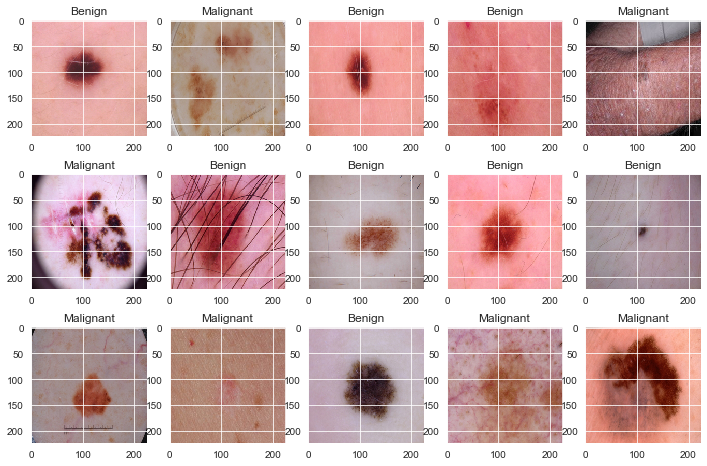

In [17]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [19]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

type(y_train)

numpy.ndarray

In [20]:
#Normalize:
x_train = x_train/255 #<--RGB value
x_test = x_test/255

In [92]:
def cnn_model(input_shape = (224, 224, 3), num_classes=2):
    
    model = Sequential()
    
   
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.25)) 
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten()) 

    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Output layer
    output = Dense(1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

    
    model.summary()
    
    optimizer= 'Adam'
    
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    
    return model  

In [93]:
run_model = cnn_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 200704)           

In [94]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, mode = 'max')

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)


history = build_model.fit(x_train, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size = 64, 
                    verbose=1,
                    callbacks=[lr_reduce, checkpoint])

print(history.history.keys())

Epoch 1/50
33/33 [==============================] - 121s 4s/step - loss: 6.9522 - accuracy: 0.5467 - val_loss: 7.0005 - val_accuracy: 0.5436
Epoch 2/50
33/33 [==============================] - 126s 4s/step - loss: 6.9522 - accuracy: 0.5467 - val_loss: 7.0005 - val_accuracy: 0.5436
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 6.9522 - accuracy: 0.5467
Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
33/33 [==============================] - 126s 4s/step - loss: 6.9522 - accuracy: 0.5467 - val_loss: 7.0005 - val_accuracy: 0.5436
Epoch 4/50
33/33 [==============================] - 126s 4s/step - loss: 6.9522 - accuracy: 0.5467 - val_loss: 7.0005 - val_accuracy: 0.5436
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 6.9522 - accuracy: 0.5467
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
33/33 [==============================] - 127s 4s/step - loss: 6.9522 - accuracy: 0.5467 - val_loss

KeyboardInterrupt: 

In [76]:
#Values for later use:
img_dims = 150
epochs = 50
batch_size = 32

In [77]:
# In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
test_data = []
test_labels = []

for cond in ['/benign/', '/malignant/']:
     for img in (os.listdir(main_dir + 'test' + cond)):
            img = plt.imread(main_dir+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/benign/':
                label = 0
            elif cond=='/malignant/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    

In [53]:
x_train.shape

(2637, 224, 224, 3)

In [54]:
x_test.shape

(660, 224, 224, 3)

In [ ]:
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [34]:
import math

In [37]:
trainingsize= 2637
validatesize=660

In [55]:
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(trainingsize)
val_steps = compute_steps_per_epoch(validatesize)

In [78]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(2, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [79]:
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_88 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_89 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_44 (Batc (None, 75, 75, 32)      

In [69]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    steps_per_epoch=len(x_train)//128,
                    validation_data= (x_test, y_test),
                    callbacks=[early_stop, checkpoint, lr_reduce])

Epoch 1/50


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [128,2] and labels shape [256]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-69-72ef7e11b2f2>:1) ]] [Op:__inference_train_function_17350]

Function call stack:
train_function
